In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv


## Import the necessary dependecies 

In [2]:

# utilities
import re
import numpy as np
import pandas as pd
import string

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc



/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Load the data

In [3]:
data=pd.read_csv("/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv")
data.head(3)

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0


In [4]:
data.shape

(10314, 3)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [6]:
# check for null values
np.sum(data.isnull().any(axis=1))

0

<AxesSubplot:xlabel='label', ylabel='count'>

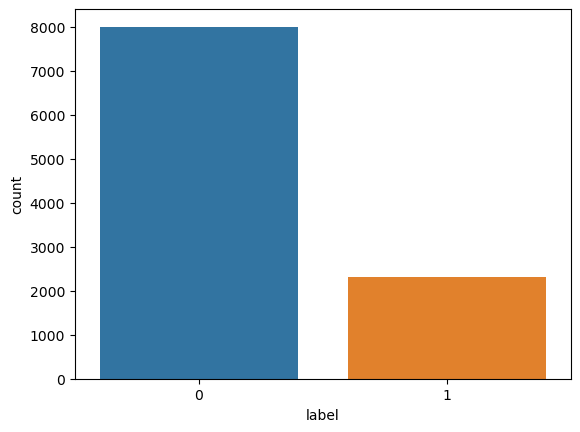

In [7]:
# check for label values, helps to figure out imbalanced classes

data = data.rename(columns={'message to examine': 'text', 'label (depression result)': 'label'})
sns.countplot(x='label', data=data)

## Data Pre-processing

In [8]:
dataset=data[['text','label']]
dataset = dataset.iloc[:-1 , :]

In [9]:
data_pos = dataset[dataset['label'] == 1]
data_neg = dataset[dataset['label'] == 0]

In [10]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

10308    many sufferers of depression aren't sad; they ...
10309    no depression by g herbo is my mood from now o...
10310    what do you do when depression succumbs the br...
10311    ketamine nasal spray shows promise against dep...
10312    dont mistake a bad day with depression! everyo...
Name: text, dtype: object

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
list(stopwords)[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
STOPWORDS = set(stopwords)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

0                 real good moment. missssssssss much,
1               reading manga http://plurk.com/p/mzp1e
2    @comeagainjen http://twitpic.com/2y2lx - http:...
3    @lapcat need send 'em accountant tomorrow. odd...
4               add myspace!!! myspace.com/lookthunder
Name: text, dtype: object

In [13]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

0                 real good moment. missssssssss much,
1                                      reading manga  
2                                      @comeagainjen  
3    @lapcat need send 'em accountant tomorrow. odd...
4               add myspace!!! myspace.com/lookthunder
Name: text, dtype: object

In [14]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

0                   real good moment missssssssss much
1                                      reading manga  
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: text, dtype: object

In [15]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].head()

0                   real good moment missssssssss much
1                                      reading manga  
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: text, dtype: object

In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

0                   real good moment missssssssss much
1                                      reading manga  
2                                       comeagainjen  
3    lapcat need send em accountant tomorrow oddly ...
4                    add myspace myspacecomlookthunder
Name: text, dtype: object

In [17]:
# splits a string into substrings using a regular expression
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

0     []
1     []
2     []
3    [w]
4     []
Name: text, dtype: object

In [18]:
# Stemmers remove morphological affixes from words, leaving only the word stem.
st = nltk.PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

0     []
1     []
2     []
3    [w]
4     []
Name: text, dtype: object

In [19]:
# in kaggle: !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# in local machine: sudo python -m nltk.downloader -d /usr/local/share/nltk_data all

# Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. 


!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
lm = WordNetLemmatizer()

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

0     []
1     []
2     []
3    [w]
4     []
Name: text, dtype: object

In [20]:
X=data.text
y=data.label

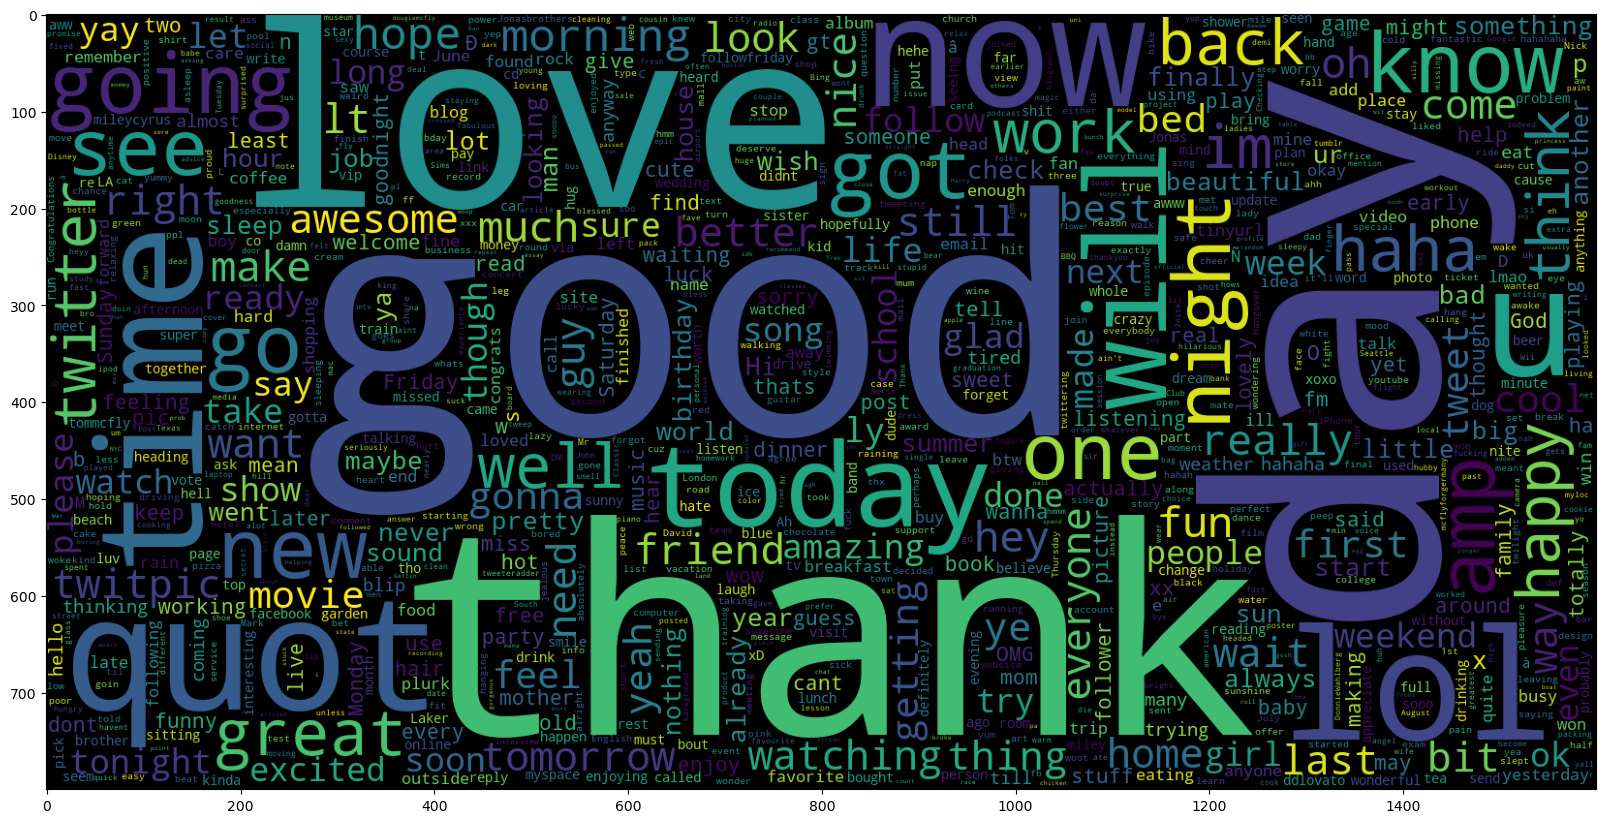

In [21]:
data_neg = data['text'][:8000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

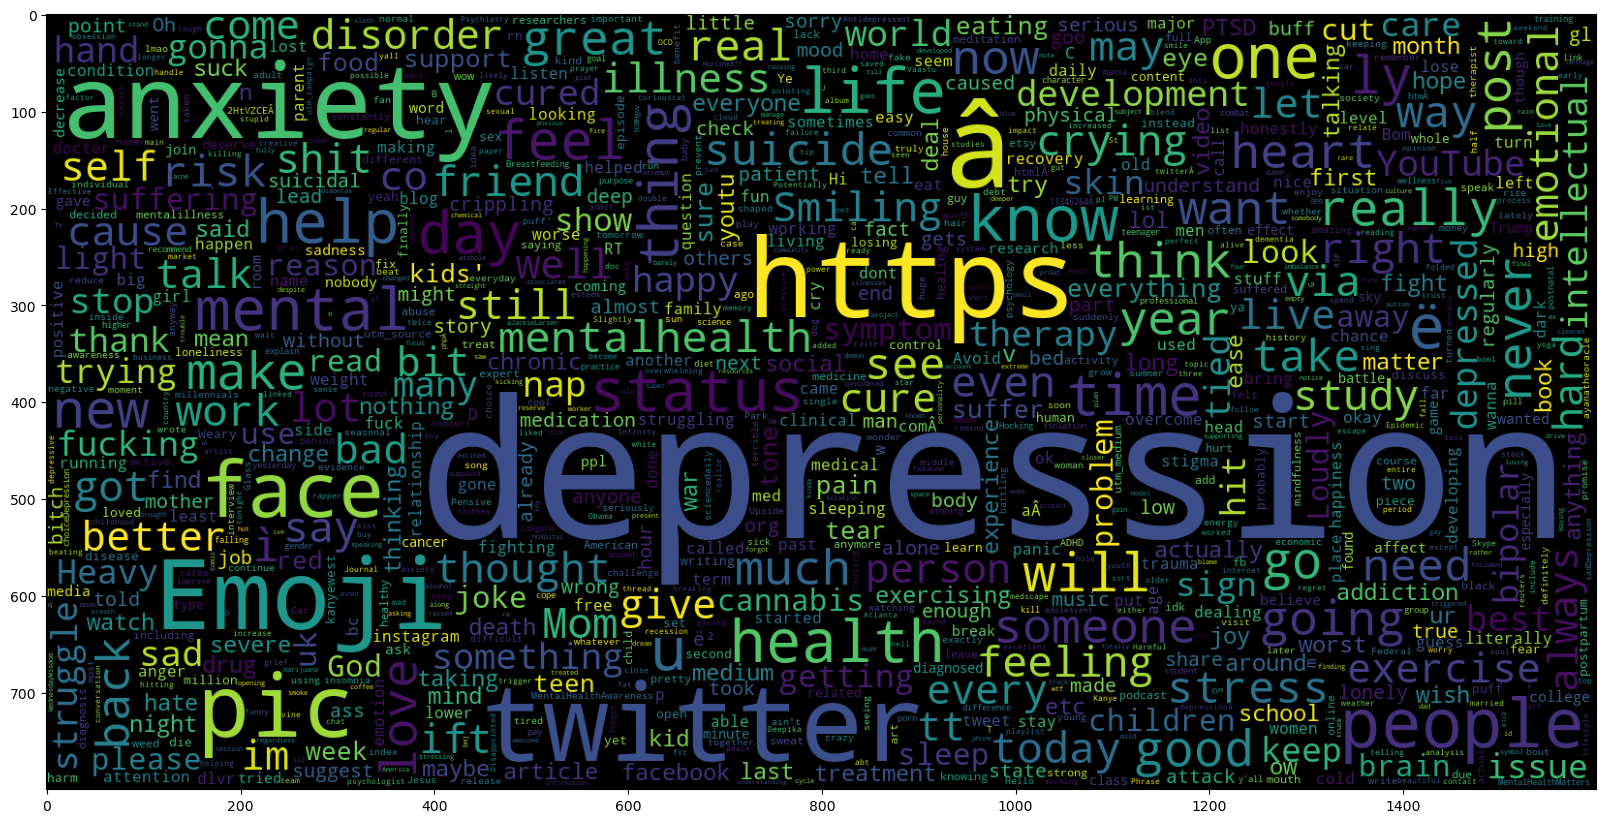

In [22]:
data_pos = data['text'][8000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


In [23]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [24]:
#Fit the TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  105037


In [25]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [26]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [27]:
def generate_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

### Model Building

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       386
           1       1.00      0.46      0.63       130

    accuracy                           0.86       516
   macro avg       0.92      0.73      0.77       516
weighted avg       0.89      0.86      0.84       516



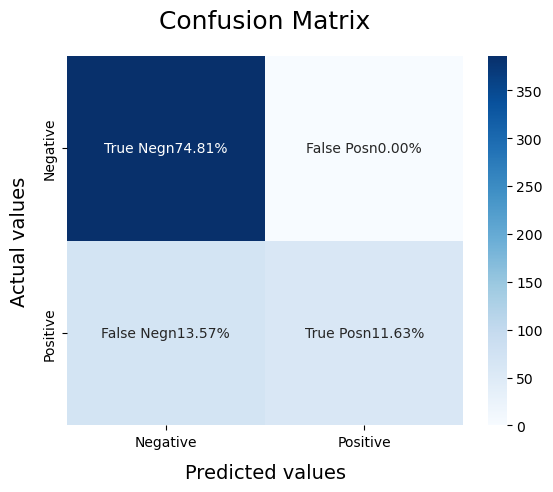

In [28]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

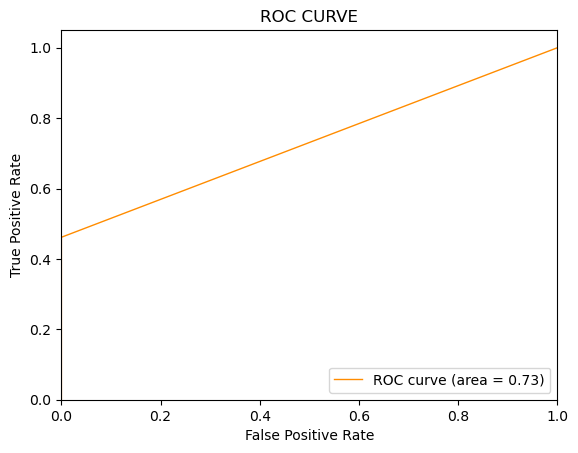

In [29]:
 generate_roc_curve(y_test, y_pred1)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       386
           1       1.00      0.98      0.99       130

    accuracy                           0.99       516
   macro avg       1.00      0.99      0.99       516
weighted avg       0.99      0.99      0.99       516



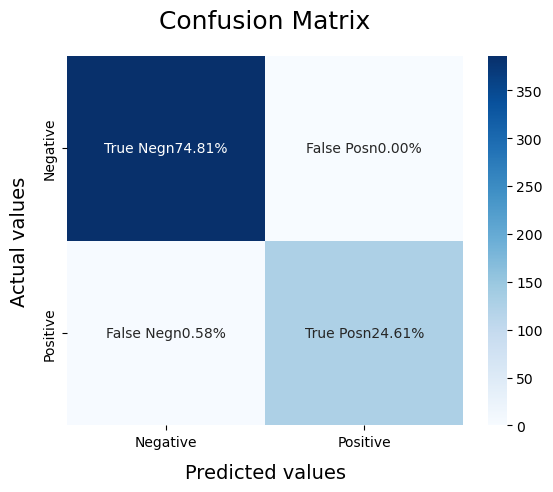

In [30]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

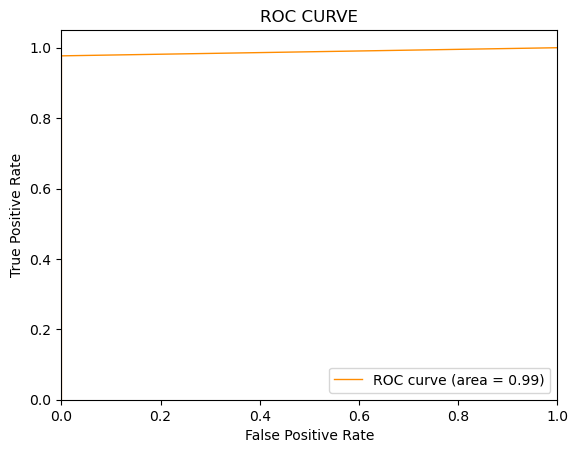

In [31]:
generate_roc_curve(y_test, y_pred2)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       386
           1       1.00      0.97      0.98       130

    accuracy                           0.99       516
   macro avg       0.99      0.98      0.99       516
weighted avg       0.99      0.99      0.99       516



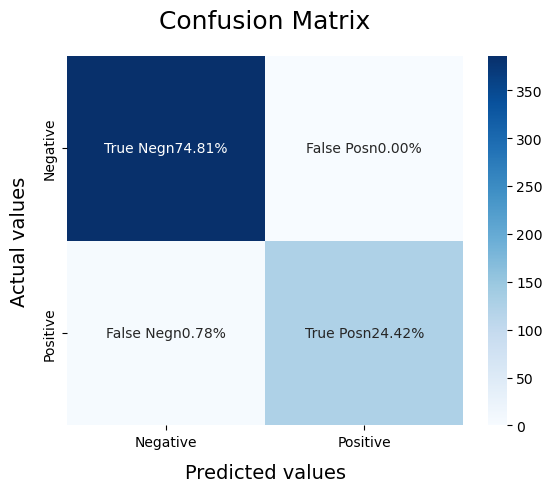

In [32]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

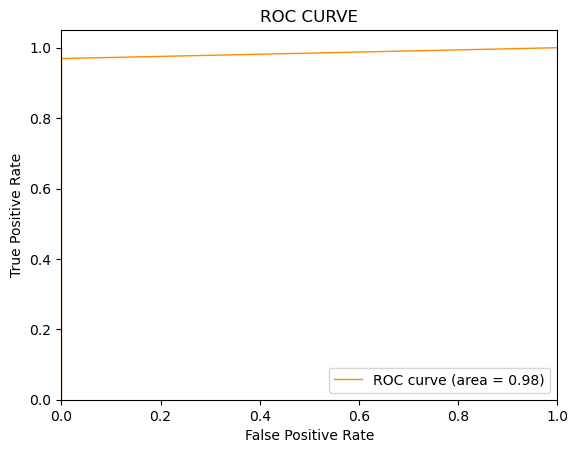

In [33]:
generate_roc_curve(y_test, y_pred3)